# QBAF-Py: Examples
This noteboook provides some examples for how to use QBAF-Py.

## Instantiating QBAFs
Let us first instantiate a QBAF.

In [1]:
from qbaf import QBAFramework, QBAFARelations

args = ['a', 'b', 'c', 'd', 'e', 'f']
initial_strengths = [0.5, 0.2, 0.85, 0.65, 0.4, 1]
atts = [('c', 'a'), ('e', 'b'), ('f', 'c')]
supps = [('b', 'a'), ('d', 'a'), ('e', 'c')]
qbaf_0 = QBAFramework(args, initial_strengths, atts, supps, semantics="QuadraticEnergy_model")


The semantics that will later be applied is tied to the QBAF instantiation.
Here, we specify the quadratic energy semantics.
Note that QBAF-Py is for argumentation-based reasoning and not for visualization, so we have to take care of the visualization ourself.

In [2]:
%%capture
# To visualize the QBAFs, the networkx and pygraphviz libraries are required.
# We install them below, but depending on your setup, you may need to install them differently
!pip install networkx
!pip install pygraphviz

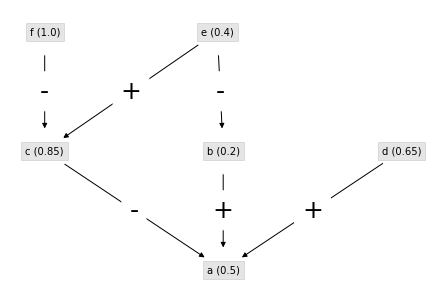

In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


def visualize(qbaf: QBAFramework, with_fs=False, round_to=2):
    """
    Takes a QBAF and renders it as a graph
    
    Args:
            qbaf (QBAFramework): The QBAF that is supposed to be rendered
            with_fs (Bool): Set to `True` if final strenghts should be rendered as well.
                            Defaults to `False`.
            round_to (int): Number of decimals the strengths should be rounded to before rendering.
                            Defaults to `2`.
            
    """
    args = qbaf.arguments
    initial_strengths = qbaf_0.initial_weights
    for key, value in initial_strengths.items():
        initial_strengths[key] = round(value, round_to)
    if with_fs:
        final_strengths = qbaf.final_weights
        for key, value in final_strengths.items():
            final_strengths[key] = round(value, round_to)
    graph = nx.DiGraph()
    nodes = {}
    for arg in args:
        if with_fs:
            label = f'{arg} ({initial_strengths[arg]}): {final_strengths[arg]}'
        else:
            label = f'{arg} ({initial_strengths[arg]})'
        graph.add_node(label)
        nodes[arg] = label   
    labels = {}
    for att in qbaf.attack_relations.relations:
        labels[(nodes[att[0]], nodes[att[1]])] = '-'
        graph.add_edge(nodes[att[0]], nodes[att[1]])
    for supp in qbaf.support_relations.relations:
        labels[(nodes[supp[0]], nodes[supp[1]])] = '+'
        graph.add_edge(nodes[supp[0]], nodes[supp[1]])
    pos = graphviz_layout(graph, prog='dot')
    nx.draw(graph, pos, with_labels=True, node_size=2000, font_size=10, node_color='#FFF',bbox=dict(facecolor='black', alpha=0.1))
    nx.draw_networkx_edge_labels(
    graph, pos,
    edge_labels=labels,
    font_size=25,
    rotate=False
    )

visualize(qbaf_0)


## Drawing Inferences
As we have instantiated our QBAF with a specific semantics, the inferences (final strengths) are readily available:

In [4]:
final_strengths = qbaf_0.final_weights
print(final_strengths)

{'e': 0.4, 'b': 0.1724137931034483, 'd': 0.65, 'f': 1.0, 'c': 0.625, 'a': 0.5187551724162596}


We update the visualizations to also show the final strengths of the arguments.
For this, we call our visualization function, with the parameter `with_fs` set to `True`.

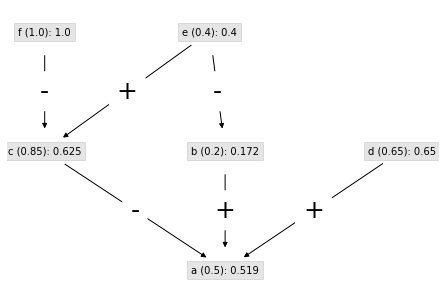

In [5]:
visualize(qbaf_0, with_fs=True, round_to=3)

## Generating Explanations
Given two argumentation frameworks and two arguments therein (so-called *topic arguments*), we can explain changes in the relative strength of these arguments (see: Kampik and Čyras. [Explaining Change in Quantitative Bipolar Argumentation](https://www.diva-portal.org/smash/get/diva2:1690830/FULLTEXT02).

In [6]:
# TODO